In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import multiprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [20]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassification(nn.Module):  
    def training_step(self, batch):  
        images, labels = batch
        out = self(images) 
        loss = F.cross_entropy(out, labels)
        return loss

    def validating(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'Validation Loss': loss.detach(), 'Validation Accuracy': acc}

    def validating_epoch_final(self, outputs):
        batch_loss = [x['Validation Loss'] for x in outputs] 
        # each batch of the validation data
        epoch_loss = torch.stack(batch_loss).mean() 
        batch_accuracy = [x['Validation Accuracy'] for x in outputs]
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {'Validation Loss': epoch_loss.item(), 'Validation Accuracy': epoch_accuracy.item()}

    def epoch_final(self, epoch, result):
        print("Epoch [{}], Training Loss: {:.4f}, Validation Loss: {:.4f}, Validation Accuracy: {:.4f}"
              .format(epoch + 1, result['Training Loss'], result['Validation Loss'], result['Validation Accuracy']))
        
        
        

In [21]:
class ResNet(ImageClassification):
    def __init__(self):
        super().__init__()
        # Using ResNet50 pretrained model
        self.network = models.resnet50(weights="ResNet50_Weights.DEFAULT")
        features = self.network.fc.in_features
        self.network.fc = nn.Linear(features, len(garbage_classes))

    def forward(self, image):
        return torch.sigmoid(self.network(image))

    def training_step(self, batch):
        images, labels = batch  
        out = self(images) 
        loss = F.cross_entropy(out, labels)
        return loss

    def epoch_final(self, epoch, result):
        print("Epoch [{}], Training Loss: {:.4f}, Validation Loss: {:.4f}, Validation Accuracy: {:.4f}"
              .format(epoch + 1, result['Train Loss'], result['Validation Loss'], result['Validation Accuracy']))

In [7]:
def export_classification_metrics(model, dataloader, classes):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            images, labels = batch
            images = move_to_gpu(images, device)
            labels = labels.to(device)  
            outputs = model(images)
            _, preds = torch.max(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())  
            all_labels.extend(labels.cpu().numpy()) 

    for i, class_name in enumerate(classes):
        class_labels = [1 if label == i else 0 for label in all_labels]
        class_preds = [1 if pred == i else 0 for pred in all_preds]
        
        accuracy = accuracy_score(class_labels, class_preds) * 100
        precision = precision_score(class_labels, class_preds, zero_division=0) * 100
        recall = recall_score(class_labels, class_preds, zero_division=0) * 100
        f1 = f1_score(class_labels, class_preds, zero_division=0) * 100
        
        print(f'{class_name}, accuracy: {accuracy:.2f}%, precision: {precision:.2f}%, recall: {recall:.2f}%, F1 score: {f1:.2f}%')

In [8]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, restore_best_weights=True):
        self.patience = patience
        self.verbose = verbose
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False
        self.restore_best_weights = restore_best_weights
        self.best_model_weights = None

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            if self.restore_best_weights:
                self.best_model_weights = model.state_dict().copy()
            if self.verbose:
                print(f'Validation loss improved: {val_loss:.4f}')
        else:
            self.counter += 1
            if self.verbose:
                print(f'Validation loss did not improve: {val_loss:.4f}')
            if self.counter >= self.patience:
                self.early_stop = True
                if self.restore_best_weights and self.best_model_weights is not None:
                    model.load_state_dict(self.best_model_weights)
                    if self.verbose:
                        print("Restored best model weights.")

In [10]:
def plot_accuracy_per_class(model, dataloader, classes):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            images, labels = batch
            images = move_to_gpu(images, device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy()) 
            all_labels.extend(labels.cpu().numpy())

    accuracies = []
    for i, class_name in enumerate(classes):
        class_labels = [1 if label == i else 0 for label in all_labels]
        class_preds = [1 if pred == i else 0 for pred in all_preds]

        accuracy = accuracy_score(class_labels, class_preds) * 100
        accuracies.append(accuracy)

    plt.bar(classes, accuracies)
    plt.xlabel('Classes')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy per Class')
    plt.xticks(rotation=45)
    plt.show()

In [30]:
directory = 'dataset-resized'
global garbage_classes
garbage_classes = os.listdir(directory)
print(garbage_classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [31]:
# Import Transforms để chỉnh sửa ảnh
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

# Resize ảnh về kích thước 224x224 pixels và transform thành Tensor
transformations = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

# Load bộ dữ liệu và áp dụng transformations
dataset = ImageFolder(directory, transform=transformations)

Label: paper (Class No: 3)


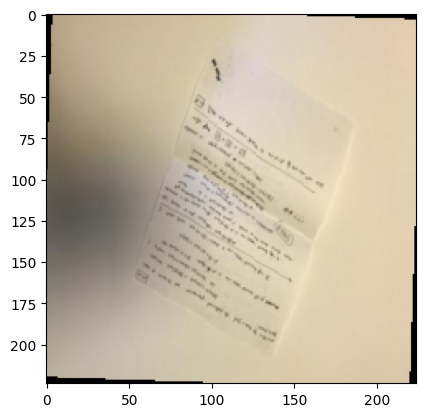

In [11]:
def display_test(image, label):
    print("Label:", dataset.classes[label], "(Class No: " + str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))
    plt.show()

# Hiển thị ảnh ngẫu nhiên từ bộ dữ liệu
image, label = dataset[random.randint(0, len(dataset))]
display_test(image, label)

In [14]:
random_seed = 43
torch.manual_seed(random_seed)

In [15]:
# Chia bộ dữ liệu thành các tập train, validate, và test
train_size = int(0.6 * len(dataset))  # 60% bộ dữ liệu
val_size = int(0.2 * len(dataset))  # 20% bộ dữ liệu
test_size = len(dataset) - train_size - val_size  # 20% bộ dữ liệu còn lại
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])
from torch.utils.data.dataloader import DataLoader
batch_size = 64

In [16]:
train = DataLoader(train_data, batch_size, shuffle=True, num_workers=4, pin_memory=True)
validation = DataLoader(val_data, batch_size * 2, num_workers=4, pin_memory=True)

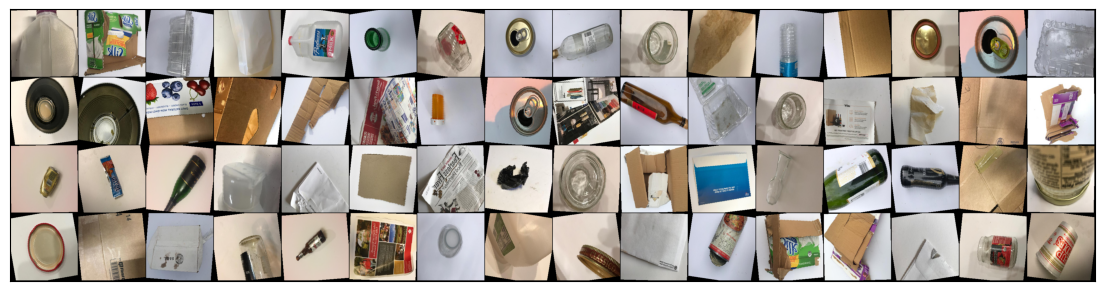

Processing via: cpu


ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [22]:
from torchvision.utils import make_grid
def batch_visualization(data):
    for image, labels in data:
        fig, ax = plt.subplots(figsize=(14, 14))
        ax.set_xticks([]);
        ax.set_yticks([])
        ax.imshow(make_grid(image, nrow=16).permute(1, 2, 0))
        plt.show()
        break

batch_visualization(train)
model = ResNet()

# Port model sang GPU
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
device = get_default_device()

# Chuyển model sang GPU
def move_to_gpu(data, device):
    if isinstance(data, (list, tuple)):
        return [move_to_gpu(x, device) for x in data]
    return data.to(device, non_blocking=True)

# DataLoading Class
class DataLoad():
    def __init__(self, data, device):
        self.data = data
        self.device = get_default_device()

    def __iter__(self):
        for batch in self.data:
            yield move_to_gpu(batch, self.device)

    def __len__(self):
        return len(self.data)

device = get_default_device()
print('Processing via:', device)  # Note: Nếu output trả về cuda, thì có thể thực hiện huấn luyện qua GPU

train = DataLoad(train, device)
validation = DataLoad(validation, device)
move_to_gpu(model, device)

In [18]:
@torch.no_grad()
def evaluate(model, validator):
    model.eval()
    outputs = [model.validating(batch) for batch in validator]
    return model.validating_epoch_final(outputs)

def opt(epochs, learning_rate, model, train_loader, validator, opt_func=torch.optim.SGD, patience = 5):
    training_history = []  # List dùng để chứa lịch sử huấn luyện
    optimizer = opt_func(model.parameters(), learning_rate)
    early_stopping = EarlyStopping(patience=patience, verbose=True)  # Thiết lập early stopping

    for epoch in range(epochs):
        model.train()  
        train_loss = []  # List dùng để lưu training loss
        for batch in train_loader:
            loss = model.training_step(batch)  # Tính toán độ loss
            train_loss.append(loss)  # Thêm loss vào danh sách
            loss.backward()  # Thực hiện truyền ngược (Backpropagate)
            optimizer.step()  # Cập nhật các tham số bằng cách sử dụng optimizer
            optimizer.zero_grad()  # Đặt lại gradient về 0 cho batch tiếp theo

        # Giai đoạn Validation
        result = evaluate(model, validator)  # Đánh giá mô hình trên tập xác thực
        result['Train Loss'] = torch.stack(train_loss).mean().item()  # Tinh toán trung bình của training loss
        model.epoch_final(epoch, result)  # Gọi phương thức epoch_final trên mô hình
        training_history.append(result)  # Thêm kết quả vào lịch sử huấn luyện
        
        # Kiểm tra early stopping
        early_stopping(result['Validation Loss'], model)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break  # Dừng việc huấn luyện nếu thỏa điều kiện kích hoạt early stopping

    return training_history

model = move_to_gpu(ResNet(), device)
evaluate(model, validation)

{'Validation Loss': 1.7867203950881958,
 'Validation Accuracy': 0.18814566731452942}

In [19]:
epoch = 50
optimizer = torch.optim.Adam
learning_rate = 0.00005
patience = 3  # Số epoch chờ để xem tình hình cải thiện của mô hình trước khi dừng huấn luyện
model_history = opt(epoch, learning_rate, model, train, validation, optimizer, patience)

Epoch [1], Training Loss: 1.7370, Validation Loss: 1.6632, Validation Accuracy: 0.6317
Validation loss improved: 1.6632
Epoch [2], Training Loss: 1.5730, Validation Loss: 1.4504, Validation Accuracy: 0.7846
Validation loss improved: 1.4504
Epoch [3], Training Loss: 1.3992, Validation Loss: 1.3050, Validation Accuracy: 0.8441
Validation loss improved: 1.3050
Epoch [4], Training Loss: 1.2781, Validation Loss: 1.2214, Validation Accuracy: 0.8693
Validation loss improved: 1.2214
Epoch [5], Training Loss: 1.1988, Validation Loss: 1.1808, Validation Accuracy: 0.9048
Validation loss improved: 1.1808
Epoch [6], Training Loss: 1.1526, Validation Loss: 1.1616, Validation Accuracy: 0.9188
Validation loss improved: 1.1616
Epoch [7], Training Loss: 1.1269, Validation Loss: 1.1398, Validation Accuracy: 0.9251
Validation loss improved: 1.1398
Epoch [8], Training Loss: 1.0989, Validation Loss: 1.1302, Validation Accuracy: 0.9349
Validation loss improved: 1.1302
Epoch [9], Training Loss: 1.0865, Valida

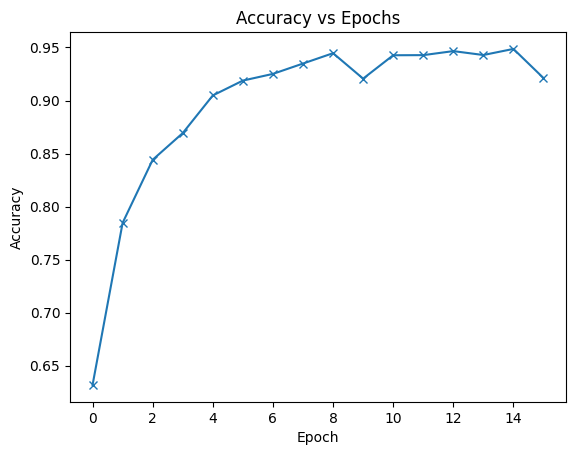

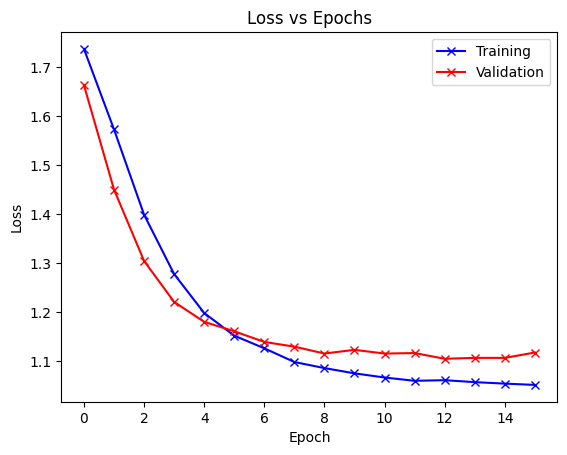

In [20]:
def plot_accuracy(model_history):
    accuracies = [x['Validation Accuracy'] for x in model_history]
    plt.plot(accuracies, '-x')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Epochs')
    plt.show()
plot_accuracy(model_history)

def plot_loss(model_history):
    train_loss = [x.get('Train Loss') for x in model_history]
    validation_loss = [x['Validation Loss'] for x in model_history]
    plt.plot(train_loss, '-bx')
    plt.plot(validation_loss, '-rx')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs Epochs')
    plt.show()
plot_loss(model_history)

cardboard, accuracy: 99.01%, precision: 97.01%, recall: 95.59%, F1 score: 96.30%
glass, accuracy: 96.83%, precision: 95.00%, recall: 91.94%, F1 score: 93.44%
metal, accuracy: 97.82%, precision: 95.89%, recall: 89.74%, F1 score: 92.72%
paper, accuracy: 97.23%, precision: 96.40%, recall: 91.45%, F1 score: 93.86%
plastic, accuracy: 96.63%, precision: 87.96%, recall: 95.96%, F1 score: 91.79%
trash, accuracy: 97.43%, precision: 61.54%, recall: 84.21%, F1 score: 71.11%


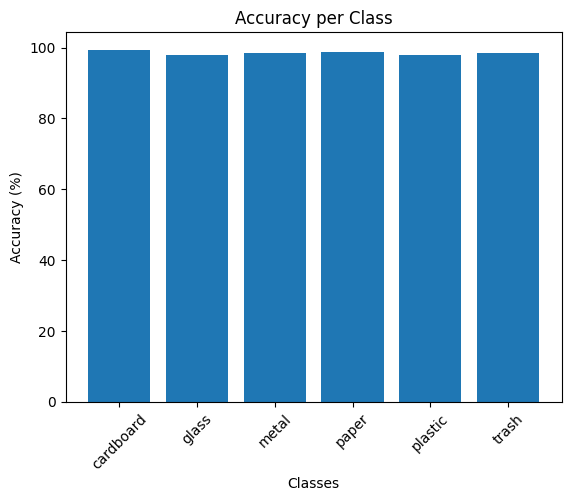

In [21]:
export_classification_metrics(model, validation, garbage_classes)
plot_accuracy_per_class(model, validation, garbage_classes)

<Figure size 1000x1000 with 0 Axes>

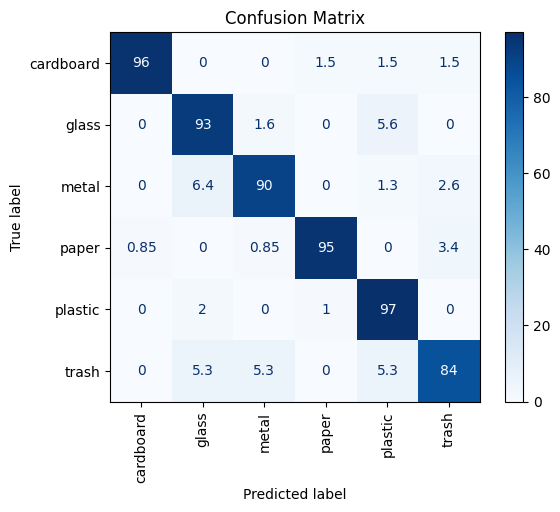

In [22]:
def plot_confusion_matrix(model, dataloader, classes):
    model.eval() 
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            images, labels = batch
            images = move_to_gpu(images, device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())  
            all_labels.extend(labels.cpu().numpy()) 

    # Tạo confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Normalize to get percentages
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=classes)

    # Vẽ confusion matrix
    plt.figure(figsize=(10, 10))
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.show()
plot_confusion_matrix(model, validation, garbage_classes)

In [32]:
def predict(image, model):
    xb = move_to_gpu(image.unsqueeze(0), device)
    # Nhận dự đoán từ mô hình
    yb = model(xb)
    # Chọn index với xác xuất cao nhất
    _, preds = torch.max(yb, dim=1)
    # Truy xuất class label
    return dataset.classes[preds[0].item()]

Testing No.1 - Class: glass , Predicted Class: glass


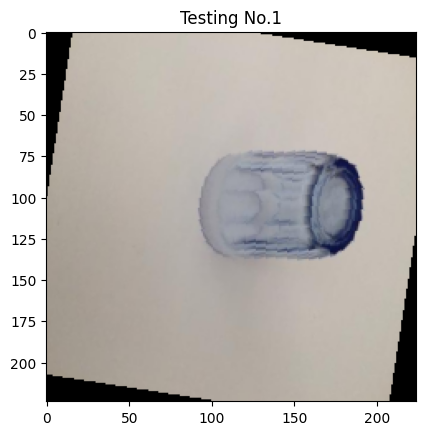

In [33]:
img, label = random.choice(dataset)
plt.imshow(img.permute(1, 2, 0))
print('Testing No.1 - Class:', dataset.classes[label], ', Predicted Class:', predict(img, model))
plt.title('Testing No.1')
plt.show()

Testing No.2 - Class: cardboard , Predicted Class: cardboard


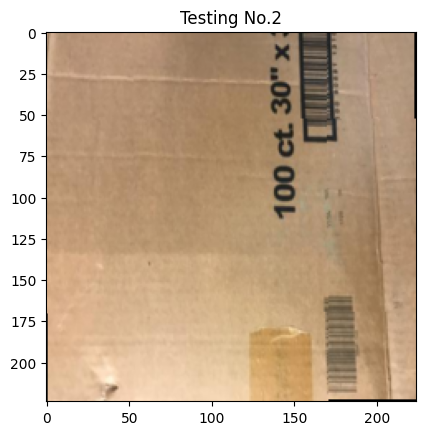

In [34]:
img, label = random.choice(dataset)
plt.imshow(img.permute(1, 2, 0))
print('Testing No.2 - Class:', dataset.classes[label], ', Predicted Class:', predict(img, model))
plt.title('Testing No.2')
plt.show()

Testing No.3 - Class: plastic , Predicted Class: plastic


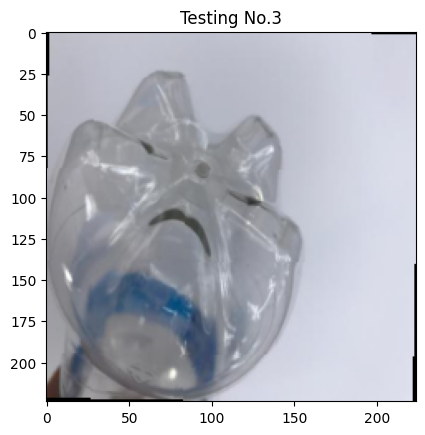

In [35]:
img, label = random.choice(dataset)
plt.imshow(img.permute(1, 2, 0)) 
print('Testing No.3 - Class:', dataset.classes[label], ', Predicted Class:', predict(img, model))
plt.title('Testing No.3')
plt.show()

In [28]:
FILE = "ResnetModel.pth"
model_scripted = torch.jit.script(model)
torch.jit.save(model_scripted, FILE)

In [1]:
import torch

# Load mô hình từ file TorchScript
model = torch.jit.load('ResnetModel.pth')
model.eval()  # Chuyển mô hình sang chế độ eval

RecursiveScriptModule(
  original_name=ResNet
  (network): RecursiveScriptModule(
    original_name=ResNet
    (conv1): RecursiveScriptModule(original_name=Conv2d)
    (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
    (relu): RecursiveScriptModule(original_name=ReLU)
    (maxpool): RecursiveScriptModule(original_name=MaxPool2d)
    (layer1): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(
        original_name=Bottleneck
        (conv1): RecursiveScriptModule(original_name=Conv2d)
        (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
        (conv2): RecursiveScriptModule(original_name=Conv2d)
        (bn2): RecursiveScriptModule(original_name=BatchNorm2d)
        (conv3): RecursiveScriptModule(original_name=Conv2d)
        (bn3): RecursiveScriptModule(original_name=BatchNorm2d)
        (relu): RecursiveScriptModule(original_name=ReLU)
        (downsample): RecursiveScriptModule(
          original_name=Sequential
          (0

In [7]:
import torch
import cv2
import torchvision.transforms as transforms

# Load mô hình TorchScript
model = torch.jit.load('ResnetModel.pth')
model.eval()  # Chuyển mô hình sang chế độ eval

# Kết nối với camera
cap = cv2.VideoCapture(1)  # 0 là camera mặc định, 1 là camera ngoài

# Định nghĩa các biến đổi hình ảnh
transform = transforms.Compose([
    transforms.ToPILImage(),  # Chuyển đổi từ numpy array sang PIL Image
    transforms.Resize((224, 224)),  # Resize hình ảnh về kích thước 224x224
    transforms.ToTensor(),  # Chuyển đổi thành tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Chuẩn hóa
])

# Vòng lặp để đọc hình ảnh từ camera
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Chuyển đổi hình ảnh để phù hợp với đầu vào của mô hình
    input_image = transform(frame).unsqueeze(0)  # Thêm chiều batch (batch size = 1)

    # Dự đoán
    with torch.no_grad():
        output = model(input_image)
        _, predicted = torch.max(output, 1)

    # Lấy tên lớp dự đoán
    predicted_class = garbage_classes[predicted.item()]

    # Hiển thị kết quả
    cv2.putText(frame, f'Class: {predicted_class}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imshow('Trash Detection', frame)

    # Nhấn 'q' để thoát
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Giải phóng camera và đóng cửa sổ
cap.release()
cv2.destroyAllWindows()

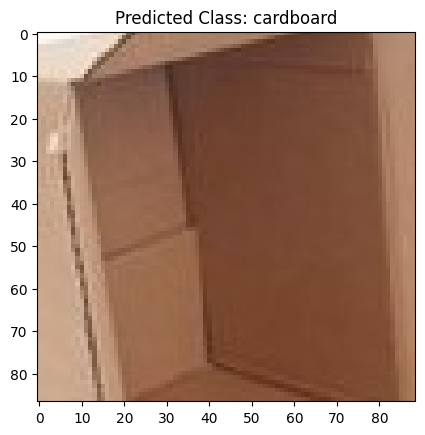

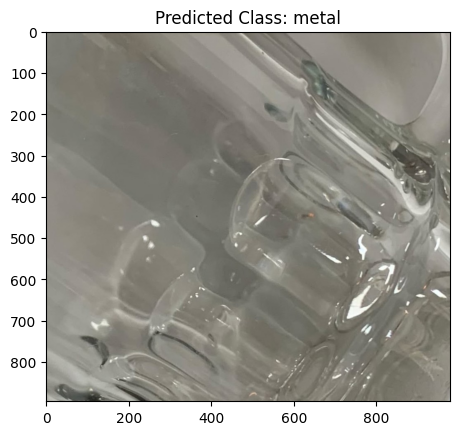

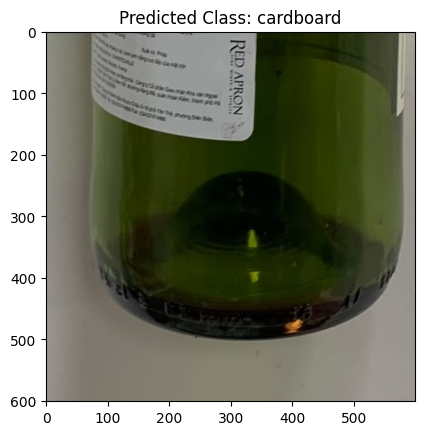

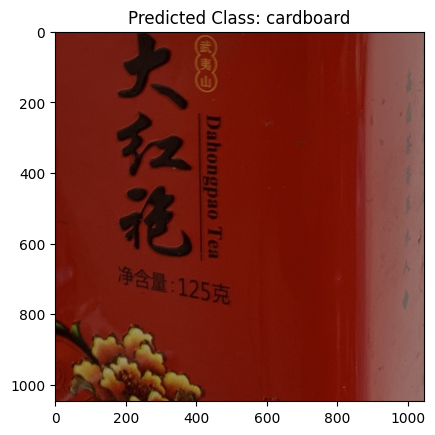

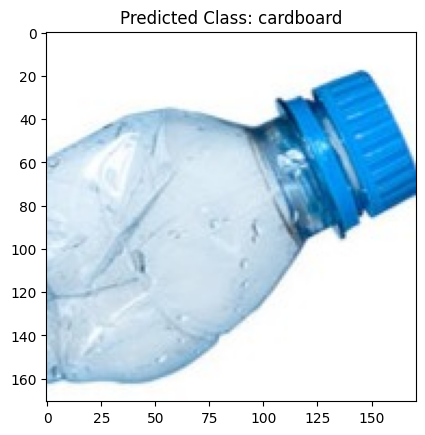

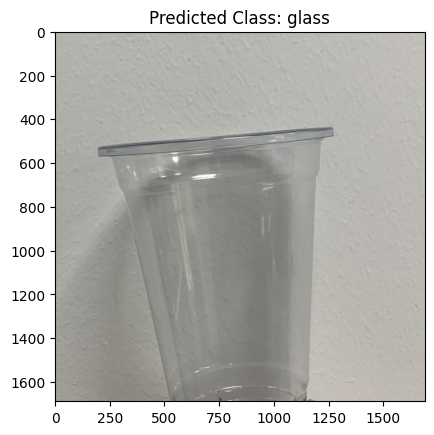

In [37]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import os

# Load mô hình TorchScript
model = torch.jit.load('ResnetModel.pth')
model.eval()  # Chuyển mô hình sang chế độ eval

# Định nghĩa các biến đổi hình ảnh
transformations = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize hình ảnh về kích thước 224x224
    transforms.ToTensor(),  # Chuyển đổi thành tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Chuẩn hóa
])

# Hàm dự đoán
def predict(image, model):
    # Chuyển đổi hình ảnh để phù hợp với đầu vào của mô hình
    input_image = transformations(image).unsqueeze(0)  # Thêm chiều batch (batch size = 1)
    
    # Dự đoán
    with torch.no_grad():
        output = model(input_image)
        _, predicted = torch.max(output, 1)
    
    # Lấy tên lớp dự đoán
    predicted_class = garbage_classes[predicted.item()]
    return predicted_class

# Đường dẫn đến thư mục chứa hình ảnh
directory = 'trash_dataset_test'

# Lặp qua tất cả các hình ảnh trong thư mục
for filename in os.listdir(directory):
    if filename.endswith('.jpg') or filename.endswith('.png'):  # Chỉ xử lý file ảnh
        # Đọc hình ảnh
        image_path = os.path.join(directory, filename)
        image = Image.open(image_path)

        # Dự đoán lớp của hình ảnh
        predicted_class = predict(image, model)

        # Hiển thị hình ảnh và kết quả dự đoán
        plt.imshow(image)
        plt.title(f'Predicted Class: {predicted_class}')
        plt.show()